In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%pip install vaderSentiment

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import math
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [10, 10]
from textblob import TextBlob
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/final-complete-datasetii/final_complete_datasetII.csv
/kaggle/input/bitcoin-tweets/Bitcoin_tweets_dataset_2.csv
/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv
/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/Bitcoin_29_10_2023-28_10_2024_historical_data.csv
/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/Ethereum 2024.csv
/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/ETH-USD (2017-2024).csv
/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/Bitcoin 2024.csv
/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/ET

Read the Tweets file save as a Pandas data frame

In [2]:
#n=10**6 #chunk size
#file1 = pd.read_csv('/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv',chunksize=n,lineterminator='\n')
#df_tweets1 = pd.concat(file1)
#print(df_tweets1.shape)

#file2 = pd.read_csv('/kaggle/input/bitcoin-tweets/Bitcoin_tweets_dataset_2.csv',chunksize=n,lineterminator='\n')
#df_tweets2 = pd.concat(file2)
#print(df_tweets2.shape)

df_raw_combo = pd.read_csv("/kaggle/input/final-complete-datasetii/final_complete_datasetII.csv",engine="python")

#df_raw = pd.read_csv("/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv",engine="python")
#df_raw2= pd.read_csv("/kaggle/input/bitcoin-tweets/Bitcoin_tweets_dataset_2.csv", engine='python')


Combined 2 dataframes

In [3]:
#df_raw_combo = pd.concat([df_tweets1, df_tweets2], ignore_index=True)
#df_raw_combo.shape

#df_raw_combo = pd.concat([df_raw, df_raw2]).drop_duplicates()
print(df_raw_combo.shape)

(2329182, 24)


Remove rows with no date or text and remove duplicates

In [4]:
df_raw_combo.dropna(axis=0 ,subset=['date','text'],inplace = True)
df_raw_combo.reset_index(drop= True,inplace=True)

df_raw_combo.drop_duplicates(inplace = True)
df_raw_combo.reset_index(drop=True,inplace=True)

df_raw_combo.shape

(2329182, 24)

In [5]:
#df_raw_combo.drop(['user_description','user_created','user_friends','hashtags','source'],axis=1,inplace=True)

Convert columns in the dataframe to the best possible dtypes that support the data

In [6]:
df_raw_combo = df_raw_combo.convert_dtypes()
df_raw_combo.dtypes

Unnamed: 0                     Int64
user_name             string[python]
user_location         string[python]
user_description      string[python]
user_created          string[python]
user_followers                 Int64
user_friends                   Int64
user_favourites                Int64
user_verified                boolean
date                  string[python]
text                  string[python]
hashtags              string[python]
source                string[python]
is_retweet                   boolean
date_clean            string[python]
clean_text            string[python]
Subjectivity                 Float64
Polarity                     Float64
Vader_Comp                   Float64
Vader_Pos                    Float64
Vader_Neg                    Float64
Vader_Neu                    Float64
Vader_Subjectivity           Float64
sentiment             string[python]
dtype: object

In [7]:
df_raw_combo['date'] =  pd.to_datetime(df_raw_combo['date'],errors='coerce')
df_raw_combo.dropna(inplace=True)
df_raw_combo['date'] = pd.to_datetime(df_raw_combo['date'], format='%Y-%m-%d %H:%M:%S')
df_raw_combo['date_clean'] = pd.to_datetime(df_raw_combo['date'], errors='coerce').dt.strftime('%Y-%m-%d')


In [8]:
df_raw_combo['Follower_Size'] = 'Other'  # Initialize the 'Genre' column with 'Other' as the default value
df_raw_combo['user_followers'] = pd.to_numeric(df_raw_combo['user_followers'], errors='coerce').astype('Int64')
df_raw_combo['user_favourites'] = pd.to_numeric(df_raw_combo['user_favourites'], errors='coerce').astype('Int64')

# Using DataFrame.loc[] to set values based on the condition
df_raw_combo.loc[(df_raw_combo['user_followers'] >= 10) & (df_raw_combo['user_followers'] < 100), 'Follower_Size'] = '10 - 99  followers'
df_raw_combo.loc[(df_raw_combo['user_followers'] >= 100) & (df_raw_combo['user_followers'] < 1000), 'Follower_Size'] = '100 - 999 followers'
df_raw_combo.loc[(df_raw_combo['user_followers'] >= 1000) & (df_raw_combo['user_followers'] < 10000), 'Follower_Size'] = '1000 - 9999 followers'
df_raw_combo.loc[(df_raw_combo['user_followers'] >= 10000) & (df_raw_combo['user_followers'] < 100000), 'Follower_Size'] = '10000 - 99999 followers'
df_raw_combo.loc[(df_raw_combo['user_followers'] >= 100000),  'Follower_Size'] = '100000 or more followers' 

#df_raw_combo.head()


In [9]:
df_raw_combo.shape

(2329182, 25)

In [10]:
df_tweets_portion = df_raw_combo.head(2329182)
#df_tweets_portion = df_raw_combo.head(1000000)
df_tweets_portion.shape

(2329182, 25)

To keep certain dates if needed

In [11]:
#df_tweets_portion_clean = df_tweets_portion_clean.loc[(df_tweets_portion_clean['date'] <= '2021-05-30')&(df_tweets_portion_clean['date'] >= '2022-05-30')].reset_index(drop=True)
#df_tweets_portion_clean.head()
#df_tweets_portion_clean.shape

Tweets EDA

In [12]:
#Use df_tweets_portion_clean
df_tweets_portion['date'] = pd.to_datetime(df_tweets_portion['date'])
df_tweets_portion['date'] = df_tweets_portion['date'].dt.strftime('%Y-%m-%d')
df_tweets_portion_clean = df_tweets_portion.copy()
df_tweets_portion_clean.reset_index(drop=True,inplace=True)
df_tweets_portion_clean.head()

# Find minimum and maximum date
min_date = df_tweets_portion_clean['date'].min()
max_date = df_tweets_portion_clean['date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)


,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,...,clean_text,Subjectivity,Polarity,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,Vader_Subjectivity,sentiment,Follower_Size
0,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10,...,"['blue', 'ridge', 'bank', 'share', 'halted', '...",0.1,0.0,0.296,0.128,0.0,0.872,-0.128,NEUTRAL,1000 - 9999 followers
1,4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472,10482,False,2021-02-10,...,"['network', 'secured', '9', '508', 'node', 'to...",0.2,-0.25,-0.2023,0.134,0.173,0.693,-0.307,NEUTRAL,1000 - 9999 followers
2,5,ZerrBenz™ ⚔ ✪ 20732,"Bkk, Thailand",I'm a cat slave 🐱 Interested in Blockchain · T...,2010-01-12 07:00:04,742,716,2444,False,2021-02-10,...,"['trade', 'crypto', 'binance', 'enjoy', 'cashb...",0.5,0.4,0.4939,0.176,0.0,0.824,-0.176,NEUTRAL,100 - 999 followers
3,6,Bitcoin-Bot,"Florida, USA",Bot to generate Bitcoin picture as combination...,2019-12-23 16:49:16,131,84,5728,False,2021-02-10,...,"['lt', 'fire', 'amp', 'man', 'gt', 'bitcoin', ...",0.0,0.0,-0.34,0.0,0.194,0.806,-0.194,NEUTRAL,100 - 999 followers
4,9,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10,...,"['tesla', 'bitcoin', 'investment', 'revolution...",0.4,-0.2,0.0,0.0,0.0,1.0,0.0,NEUTRAL,1000 - 9999 followers


Minimum Date: 2021-02-05
Maximum Date: 2023-03-05


In [13]:
#Use df_tweets_portion_clean
df_tweets_portion_clean = df_tweets_portion_clean.sort_values(by='date', ascending=False)

idx_most_recent = df_tweets_portion_clean.groupby('user_name')['date'].idxmax()

most_recent_entries = df_tweets_portion_clean.loc[idx_most_recent]

most_recent_followers_list = most_recent_entries['user_followers'].tolist()
most_recent_verified_list = most_recent_entries['user_verified'].tolist()

true_count = most_recent_verified_list.count(True)
false_count = most_recent_verified_list.count(False)

print("Number of verified users:", true_count)
print("Number of regular users:", false_count)

import statistics

average_followers = round(statistics.mean(most_recent_followers_list), 2)
median_followers = statistics.median(most_recent_followers_list)

print("Average followers:", average_followers)
print("Median followers:", median_followers)

Number of verified users: 3671
Number of regular users: 337703
Average followers: 4659.44
Median followers: 198.0


In [14]:
user_counts = df_tweets_portion_clean.groupby('user_name').size().tolist()

average_tweets = sum(user_counts) / len(user_counts)
mean_tweets = pd.Series(user_counts).mean()
median_tweets = statistics.median(user_counts)
max_tweets = max(user_counts)


print("Average number of tweets:", round(average_tweets,2))
print("Median number of tweets:", median_tweets)
print("Maximum number of tweets:", max_tweets)

Average number of tweets: 6.82
Median number of tweets: 1.0
Maximum number of tweets: 16786


In [15]:
df_tweets_portion_clean['user_favourites'] = pd.to_numeric(df_tweets_portion_clean['user_favourites'], errors='coerce')

df_tweets_portion_clean['user_favourites'] = df_tweets_portion_clean['user_favourites'].fillna(0)  # Replace NaN with 0, adjust as needed

df_tweets_portion_clean['user_favourites'] = df_tweets_portion_clean['user_favourites'].round(0).astype(int)

average_favourites = df_tweets_portion_clean['user_favourites'].mean()
median_favourites = df_tweets_portion_clean['user_favourites'].median()
max_favourites = df_tweets_portion_clean['user_favourites'].max()

print("Average number of likes per tweet:", round(average_favourites, 2))
print("Median number of likes per tweet:", median_favourites)
print("Maximum number of likes per tweet:", max_favourites)

Average number of likes per tweet: 9564.47
Median number of likes per tweet: 1164.0
Maximum number of likes per tweet: 1567894


In [16]:
total_rows = len(df_tweets_portion_clean)
is_retweet_counts = df_tweets_portion_clean['is_retweet'].value_counts()

num_retweets = df_tweets_portion_clean['is_retweet'].sum()

print(f"Number of retweets: {num_retweets} out of {total_rows} tweets")

Number of retweets: 0 out of 2329182 tweets


In [17]:
import nltk
nltk.download('wordnet')

#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

from zipfile import ZipFile
file_loc = '/usr/share/nltk_data/corpora/wordnet.zip'
with ZipFile(file_loc, 'r') as z:
  z.extractall('/usr/share/nltk_data/corpora/')
data = nltk.corpus.wordnet
print(data)

#data = nltk.corpus.comtrans.aligned_sents('alignment-en-fr.txt')

#!pwd

count = 0
for root, folders, filenames in os.walk('/root/nltk'):
   print(root, folders)

#!ls ..
#!pip install --upgrade nltk

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<WordNetCorpusReader in '.../corpora/wordnet' (not loaded yet)>


**Text Preprocessing**

Don't need to run preprocessing. Preprocessing already included in file.

In [18]:
#lem = WordNetLemmatizer()
#import nltk
#nltk.download("wordnet")
#nltk.data.path.append('/kaggle/input')
#import nltk
#nltk.download('stopwords')
#import nltk
#print(nltk.find('corpora/wordnet.zip'))
import nltk
nltk.download('wordnet')
# Data is downloaded to /root/nltk_data/corpora/comtrans.zip

#from zipfile import ZipFile
#file_loc = '/root/nltk_data/corpora/comtrans.zip'
#with ZipFile(file_loc, 'r') as z:
  #z.extractall('/root/nltk_data/corpora/')

#data = nltk.corpus.comtrans.aligned_sents('alignment-en-fr.txt')
#print(data[0])
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

#import nltk
#from nltk.corpus import wordnet as wn
#nltk.download('omw-1.4')
#nltk.download('wordnet')
#nltk.download('wordnet2022')
#nlp = load('en_core_web_sm')

#! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet


#def tweet_to_words(tweet):
    #''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    #text = tweet.lower()
    # remove non letters
    #text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    #words = text.split()
    # remove stopwords
    #words = [w for w in words if w not in stopwords.words("english")]
    # apply lemmatization
    #words= [lem.lemmatize(token) for token in words]
    # return list
    #return words


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
#cleantext=[]
#for item in tqdm(df_tweets_portion_clean['text']):
    #words=tweet_to_words(item)
    #cleantext+=[words]
#df_tweets_portion_clean['clean_text']=cleantext
#df_tweets_portion_clean

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. 

positive sentiment: compound score >= 0.5
neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
negative sentiment: compound score <= -0.5

Using tqdm to visualize progress since it is a large data set

In [20]:
#analyzer = SentimentIntensityAnalyzer()

#def analyze_sentiment_pos(tweet):
    #sentiment_dict = analyzer.polarity_scores(tweet)
    #return str(sentiment_dict['pos'])

#def analyze_sentiment_Neg(tweet):
    #sentiment_dict = analyzer.polarity_scores(tweet)
    #return sentiment_dict['neg']

#def analyze_sentiment_Neu(tweet):
    #sentiment_dict = analyzer.polarity_scores(tweet)
    #return sentiment_dict['neu']

#def analyze_sentiment_Comp(tweet):
    #sentiment_dict = analyzer.polarity_scores(tweet)
    #return sentiment_dict['compound']

In [21]:
#print(df_tweets_portion_clean.head())

In [22]:
#df_tweets_portion_clean["clean_text"]  = df_tweets_portion_clean["clean_text"].astype(str) 
#df_tweets_portion_clean["Vader_Comp"] = df_tweets_portion_clean['clean_text'].apply(analyze_sentiment_Comp)
#df_tweets_portion_clean["Vader_Pos"] = df_tweets_portion_clean['clean_text'].apply(analyze_sentiment_pos)
#df_tweets_portion_clean["Vader_Neg"] = df_tweets_portion_clean['clean_text'].apply(analyze_sentiment_Neg)
#df_tweets_portion_clean["Vader_Neu"] = df_tweets_portion_clean['clean_text'].apply(analyze_sentiment_Neu)
#df_tweets_portion_clean["Vader_Subjectivity"] = df_tweets_portion_clean["Vader_Neu"] - 1

In [23]:
# create a function get the sentiment text

# The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be 
#between -1 (most extreme negative) and +1 (most extreme positive). 
#This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence.
# Calling it a 'normalized, weighted composite score' is accurate.
# A compound score is the aggregate of the score of a word, or precisely, the sum of all words in the lexicon, normalized between -1 and 1
# A Subjectivity score is the inverse of the valence score for the neutral classification.

# Vader returns the sentiment value as 3 floating points value in range 0 <= score <= 1, plus one additional compound value that mixes all three in one value in range -1 <= score <= 1

#It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values are:

#positive sentiment: compound score >= 0.5
#neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
#negative sentiment: compound score <= -0.5
#subjectivity: abs(1 - neu)



def getSentiment(score):
    if score <= -0.5:
        return "NEGATIVE"
    elif score > -0.5 and score < 0.5:
        return "NEUTRAL"
    else:
        return "POSITIVE"


In [24]:
df_tweets_portion_clean['user_favourites'] = pd.to_numeric(df_tweets_portion_clean['user_favourites'], errors='coerce').astype('Int64')

df_tweets_portion_clean['Vader_Subjectivity'] = df_tweets_portion_clean['Vader_Subjectivity'].abs()
#df_tweets_portion_clean.head()

**Rescale Values**

In [25]:
# Min-Max Normalization; rescale values
df_tweets_portion_clean['normalized_followers'] = (df_tweets_portion_clean['user_followers'] - df_tweets_portion_clean['user_followers'].min())/ (df_tweets_portion_clean['user_followers'].max() - df_tweets_portion_clean['user_followers'].min())
df_tweets_portion_clean['normalized_user_favorites'] = (df_tweets_portion_clean['user_favourites'] - df_tweets_portion_clean['user_favourites'].min())/ (df_tweets_portion_clean['user_favourites'].max() - df_tweets_portion_clean['user_favourites'].min())


**Calculate Weighted Scores**

In [26]:
df_tweets_portion_clean["Weighted_Compound_Score"] =df_tweets_portion_clean['normalized_followers'] * 1 + df_tweets_portion_clean["Vader_Comp"]  + df_tweets_portion_clean['normalized_user_favorites']* 1
df_tweets_portion_clean["Weighted_Subjectivity_Score"] =df_tweets_portion_clean['normalized_followers'] * 1 + df_tweets_portion_clean["Vader_Subjectivity"]  + df_tweets_portion_clean['normalized_user_favorites']* 1



**Aggregate Weighted Scores**

In [27]:

# Aggregate Scores by Date 

weighted_average_compound_score = df_tweets_portion_clean.groupby(['date'])['Weighted_Compound_Score'].mean().reset_index()
weighted_average_subjectivity_score = df_tweets_portion_clean.groupby(['date'])['Weighted_Subjectivity_Score'].mean().reset_index()

weighted_average_compound_score.rename(columns = {'Weighted_Compound_Score':'Weighted_Average_Compound_Score'}, inplace = True) 
weighted_average_subjectivity_score.rename(columns = {'Weighted_Subjectivity_Score':'Weighted_Average_Subjectivity_Score'}, inplace = True) 


**Distibution of Subjectivity and Compound Scores**

(array([9.83655e+05, 4.33111e+05, 3.95692e+05, 2.66239e+05, 1.52269e+05,
        6.88870e+04, 2.19570e+04, 5.88100e+03, 1.41900e+03, 7.20000e+01]),
 array([0.    , 0.0988, 0.1976, 0.2964, 0.3952, 0.494 , 0.5928, 0.6916,
        0.7904, 0.8892, 0.988 ]),
 <BarContainer object of 10 artists>)

Text(0.5, 0, 'Subjectivity Score')

Text(0, 0.5, 'Number of Tweets')

Text(0.5, 1.0, 'Distribution of Subjectivity Scores in the Data')

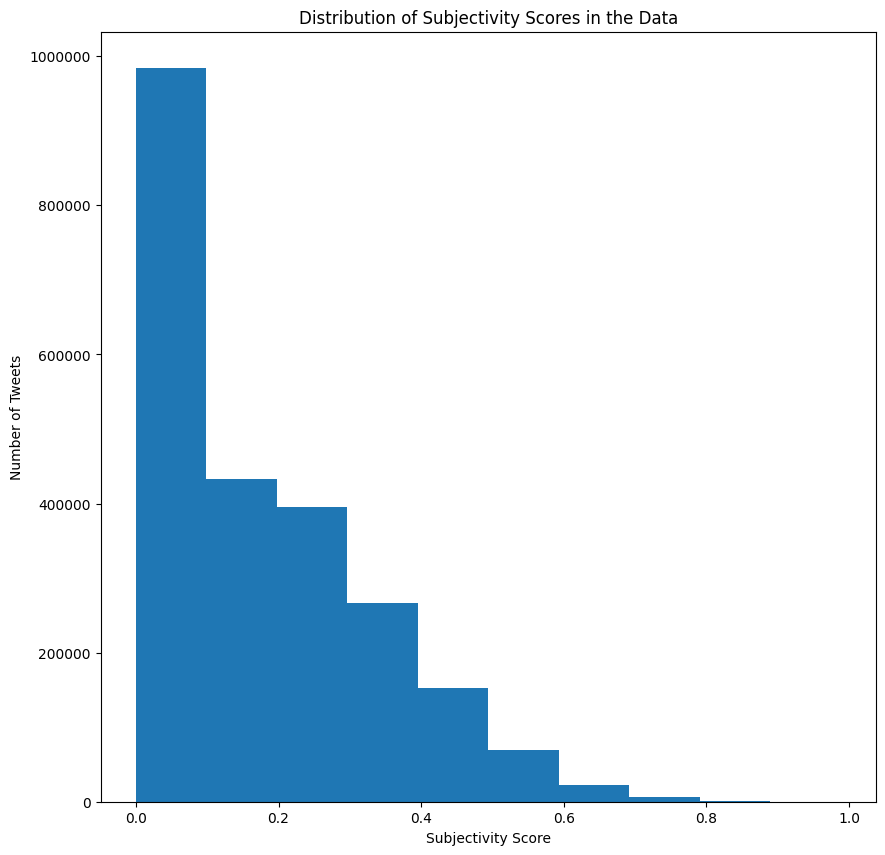

In [28]:
# Plot the distribution of subjectivity scores
plt.ticklabel_format(style='plain')
plt.hist(df_tweets_portion_clean['Vader_Subjectivity'])
plt.xlabel('Subjectivity Score')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Subjectivity Scores in the Data')
plt.show()

(array([ 21592.,  69299., 105858., 112686., 884358.,  87247., 262398.,
        300580., 280301., 204863.]),
 array([-9.9620e-01, -7.9689e-01, -5.9758e-01, -3.9827e-01, -1.9896e-01,
         3.5000e-04,  1.9966e-01,  3.9897e-01,  5.9828e-01,  7.9759e-01,
         9.9690e-01]),
 <BarContainer object of 10 artists>)

Text(0.5, 0, 'Compound Score')

Text(0, 0.5, 'Number of Tweets')

Text(0.5, 1.0, 'Distribution of Compound Scores in the Data')

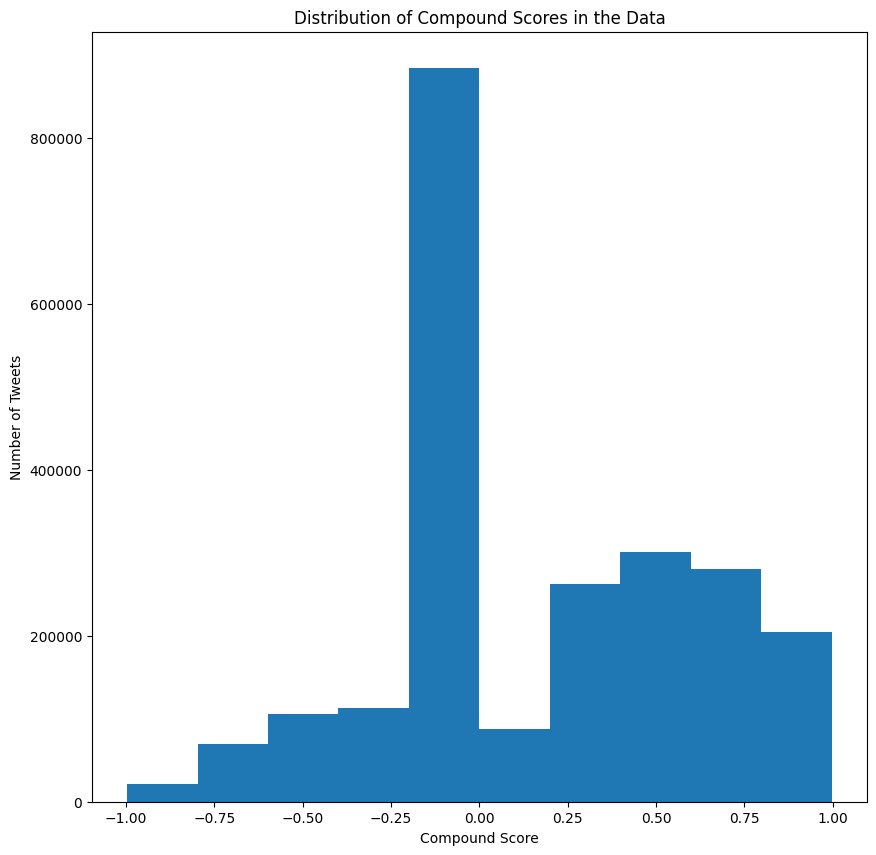

In [29]:
# Plot the distribution of compound scores
plt.ticklabel_format(style='plain')
plt.hist(df_tweets_portion_clean['Vader_Comp'])
plt.xlabel('Compound Score')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Compound Scores in the Data')
plt.show()

**Set Subjectivity Threshold and Create Weighted Scores**

In [30]:
# Subjectivity refers to the presence of opinions. The subjectivity score is on a 0 -1 scale, where scores closer to 0 indicate greater objectivity.
#Objective users are those with subjectivity ccores <=0.2. Subjective users are those with subjectivity Scores >= 0.8
#VADER does not have a subjectivity score; however, we leverage polarity scores to map subjectivity scores to the inverse of the neutral valence scores.

Objective_Users = df_tweets_portion_clean[(df_tweets_portion_clean['Vader_Subjectivity'] <= 0.2)]
Subjective_Users = df_tweets_portion_clean[(df_tweets_portion_clean['Vader_Subjectivity'] >= 0.8)]
Objective_Users_Weighted_Subjectivity = Objective_Users.groupby(['date'])['Weighted_Subjectivity_Score'].mean().reset_index()
Subjective_Users_Weighted_Subjectivity = Subjective_Users.groupby(['date'])['Weighted_Subjectivity_Score'].mean().reset_index()
Objective_Users_Weighted_Compound = Objective_Users.groupby(['date'])['Weighted_Compound_Score'].mean().reset_index()
Subjective_Users_Weighted_Compound = Subjective_Users.groupby(['date'])['Weighted_Compound_Score'].mean().reset_index()

**WordCloud ALL**

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

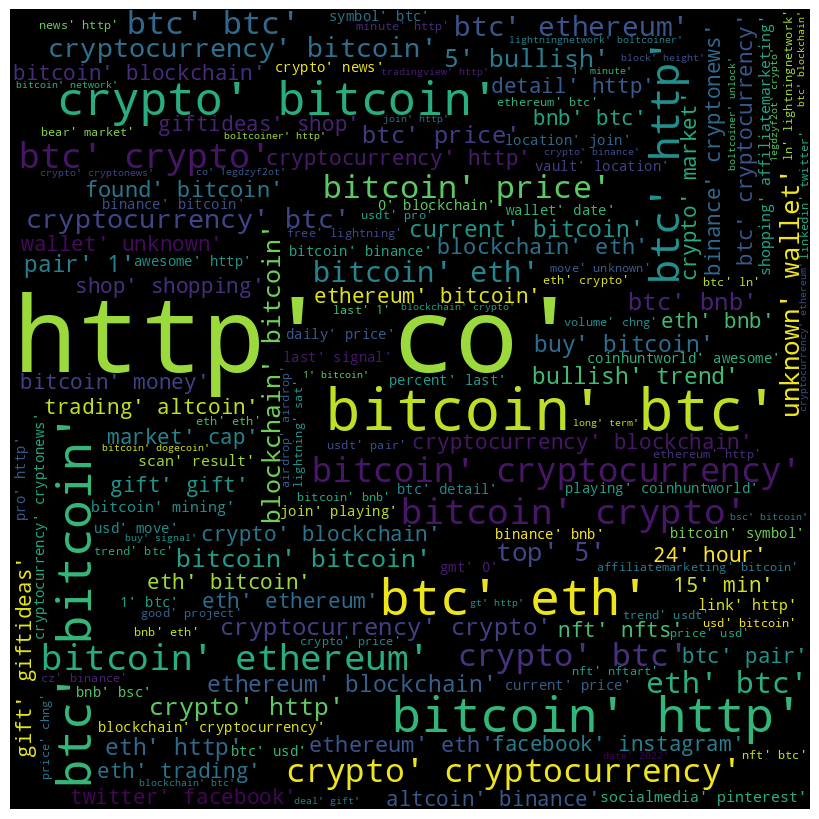

In [31]:
# wordcloud All
text = ' '.join(df_tweets_portion_clean['clean_text'])

stop_words = set(stopwords.words('english'))


# generate background
wordcloud = WordCloud(width=800, height=800, 
                background_color='black', 
                stopwords=set(stop_words),
                min_font_size=10).generate(text)

# plot
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
  
plt.show()

**Wordcloud Objective Tweets**

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

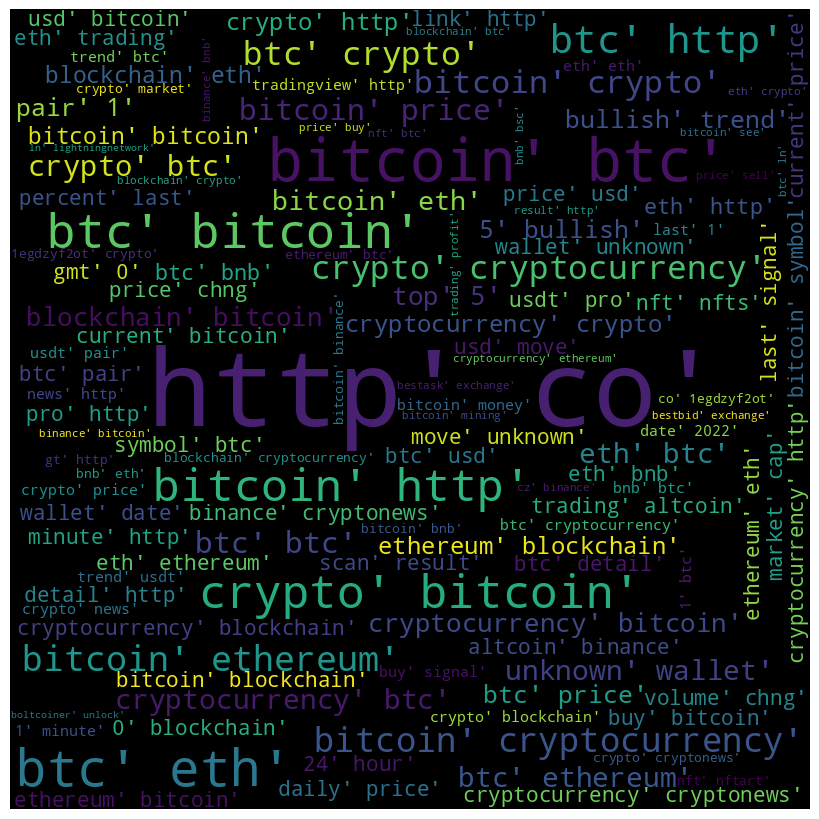

In [32]:
# wordcloud Obective
text = ' '.join(Objective_Users['clean_text'])

stop_words = set(stopwords.words('english'))


# generate background
wordcloud = WordCloud(width=800, height=800, 
                background_color='black', 
                stopwords=set(stop_words),
                min_font_size=10).generate(text)

# plot
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
  
plt.show()

**Wordcloud Subjective Tweets**

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

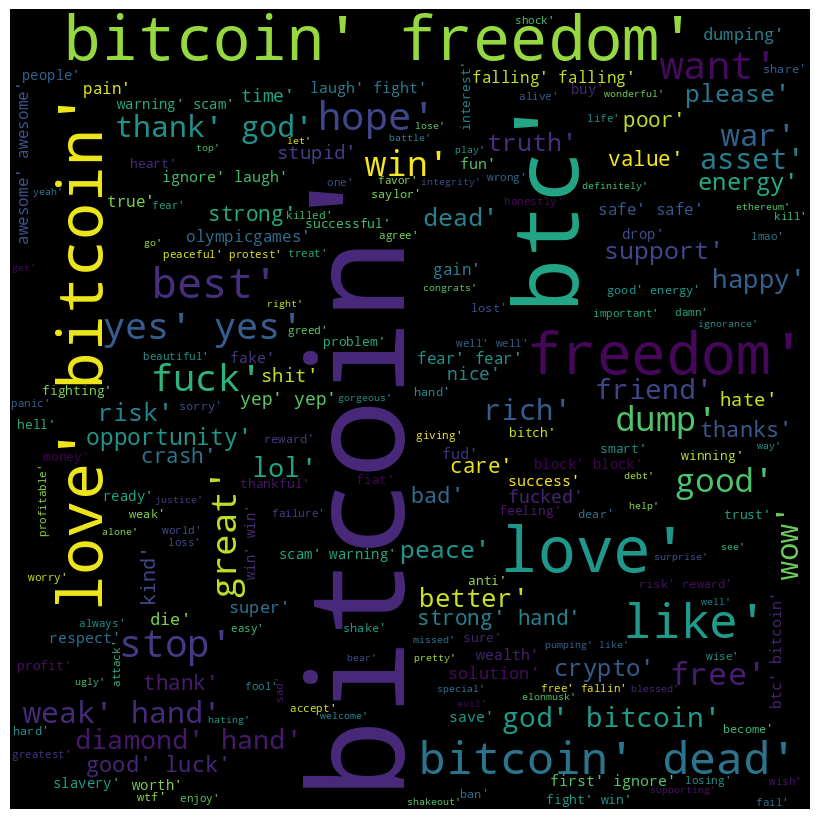

In [33]:
text = ' '.join(Subjective_Users['clean_text'])

stop_words = set(stopwords.words('english'))


# generate background
wordcloud = WordCloud(width=800, height=800, 
                background_color='black', 
                stopwords=set(stop_words),
                min_font_size=10).generate(text)

# plot
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
  
plt.show()

**Bitcoin price data set EDA**

In [34]:
import numpy as np # linear algebra
import pandas as pd


btc_price = pd.read_csv('/kaggle/input/bitcoin-and-ethereum-prices-from-start-to-2023/BTC-USD (2014-2024).csv',lineterminator='\n')
btc_price = btc_price[['Date', 'Close', 'Volume']]
btc_price = btc_price[btc_price['Date'] >= '2021-02-05']
btc_price.head()
btc_price.shape

,Date,Close,Volume
2332,2021-02-05,38144.308594,5.859807e+10
2333,2021-02-06,39266.011719,7.132603e+10
2334,2021-02-07,38903.441406,6.550064e+10
2335,2021-02-08,46196.464844,1.014672e+11
2336,2021-02-09,46481.105469,9.180985e+10


(1081, 3)

In [35]:
print("DataFrame Information:")
print(btc_price.info())

missing_values = btc_price.isnull().any(axis=1)
# Display rows with missing values
print("Rows with Missing Values:")
print(btc_price[missing_values])

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 1081 entries, 2332 to 3412
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1081 non-null   object 
 1   Close   1080 non-null   float64
 2   Volume  1080 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.8+ KB
None
Rows with Missing Values:
            Date  Close  Volume
3411  2024-01-20    NaN     NaN


In [36]:
btc_price = btc_price[btc_price['Date'] != '2024-01-20']

<Figure size 1000x600 with 0 Axes>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Close', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Bitcoin Prices')

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Frequency')

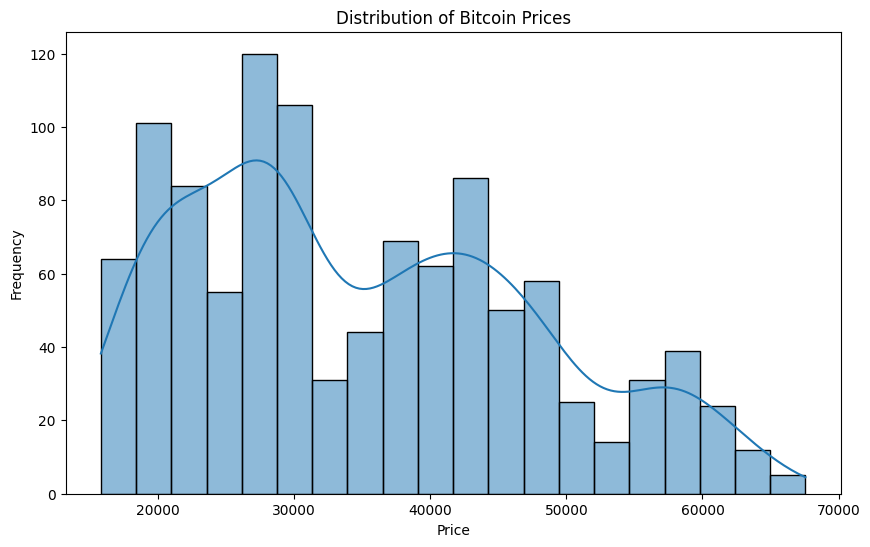

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(btc_price['Close'], bins=20, kde=True)
plt.title('Distribution of Bitcoin Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Volume', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Bitcoin Volume')

Text(0.5, 0, 'Volume')

Text(0, 0.5, 'Frequency')

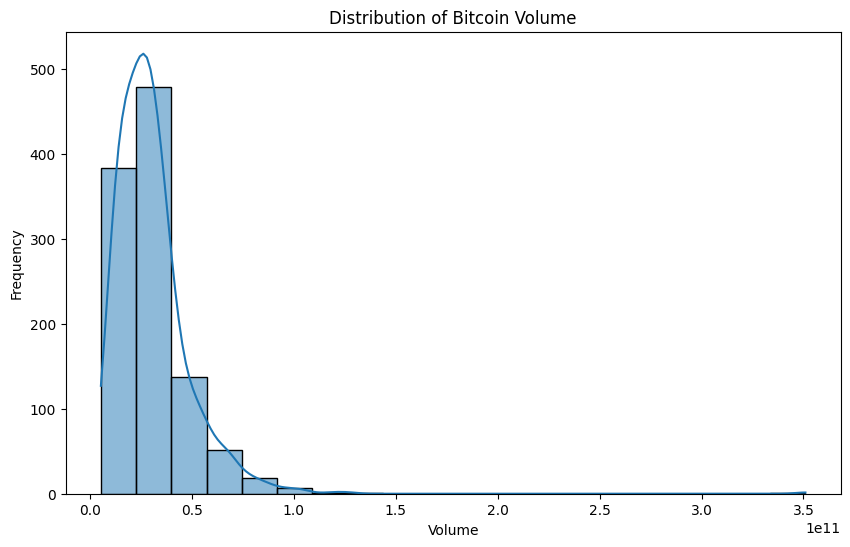

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(btc_price['Volume'], bins=20, kde=True)
plt.title('Distribution of Bitcoin Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x600 with 0 Axes>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Date', ylabel='Close'>

Text(0.5, 1.0, 'Bitcoin Price')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Price')

(array([ -31.,    0.,   31.,   59.,   90.,  120.,  151.,  181.,  212.,
         243.,  273.,  304.,  334.,  365.,  396.,  424.,  455.,  485.,
         516.,  546.,  577.,  608.,  638.,  669.,  699.,  730.,  761.,
         790.,  821.,  851.,  882.,  912.,  943.,  974., 1004., 1035.,
        1065., 1096., 1127.]),
 [Text(-31.0, 0, ''),
  Text(0.0, 0, '2021-02-05'),
  Text(31.0, 0, '2021-03-08'),
  Text(59.0, 0, '2021-04-05'),
  Text(90.0, 0, '2021-05-06'),
  Text(120.0, 0, '2021-06-05'),
  Text(151.0, 0, '2021-07-06'),
  Text(181.0, 0, '2021-08-05'),
  Text(212.0, 0, '2021-09-05'),
  Text(243.0, 0, '2021-10-06'),
  Text(273.0, 0, '2021-11-05'),
  Text(304.0, 0, '2021-12-06'),
  Text(334.0, 0, '2022-01-05'),
  Text(365.0, 0, '2022-02-05'),
  Text(396.0, 0, '2022-03-08'),
  Text(424.0, 0, '2022-04-05'),
  Text(455.0, 0, '2022-05-06'),
  Text(485.0, 0, '2022-06-05'),
  Text(516.0, 0, '2022-07-06'),
  Text(546.0, 0, '2022-08-05'),
  Text(577.0, 0, '2022-09-05'),
  Text(608.0, 0, '2022-10-06

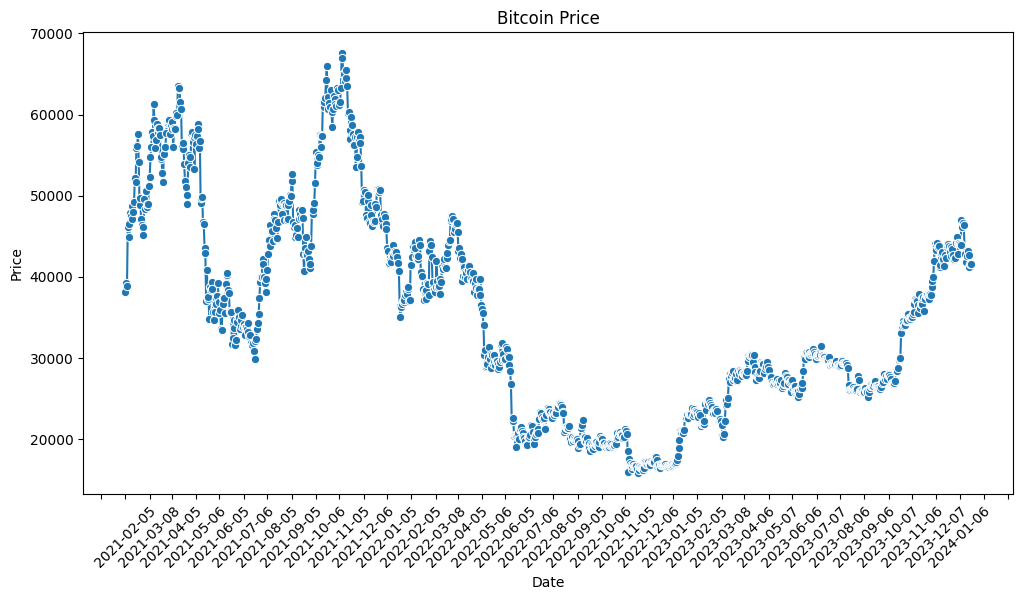

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close', data=btc_price, marker='o')

plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Date', ylabel='Volume'>

Text(0.5, 1.0, 'Bitcoin Volume')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Volume')

(array([ -31.,    0.,   31.,   59.,   90.,  120.,  151.,  181.,  212.,
         243.,  273.,  304.,  334.,  365.,  396.,  424.,  455.,  485.,
         516.,  546.,  577.,  608.,  638.,  669.,  699.,  730.,  761.,
         790.,  821.,  851.,  882.,  912.,  943.,  974., 1004., 1035.,
        1065., 1096., 1127.]),
 [Text(-31.0, 0, ''),
  Text(0.0, 0, '2021-02-05'),
  Text(31.0, 0, '2021-03-08'),
  Text(59.0, 0, '2021-04-05'),
  Text(90.0, 0, '2021-05-06'),
  Text(120.0, 0, '2021-06-05'),
  Text(151.0, 0, '2021-07-06'),
  Text(181.0, 0, '2021-08-05'),
  Text(212.0, 0, '2021-09-05'),
  Text(243.0, 0, '2021-10-06'),
  Text(273.0, 0, '2021-11-05'),
  Text(304.0, 0, '2021-12-06'),
  Text(334.0, 0, '2022-01-05'),
  Text(365.0, 0, '2022-02-05'),
  Text(396.0, 0, '2022-03-08'),
  Text(424.0, 0, '2022-04-05'),
  Text(455.0, 0, '2022-05-06'),
  Text(485.0, 0, '2022-06-05'),
  Text(516.0, 0, '2022-07-06'),
  Text(546.0, 0, '2022-08-05'),
  Text(577.0, 0, '2022-09-05'),
  Text(608.0, 0, '2022-10-06

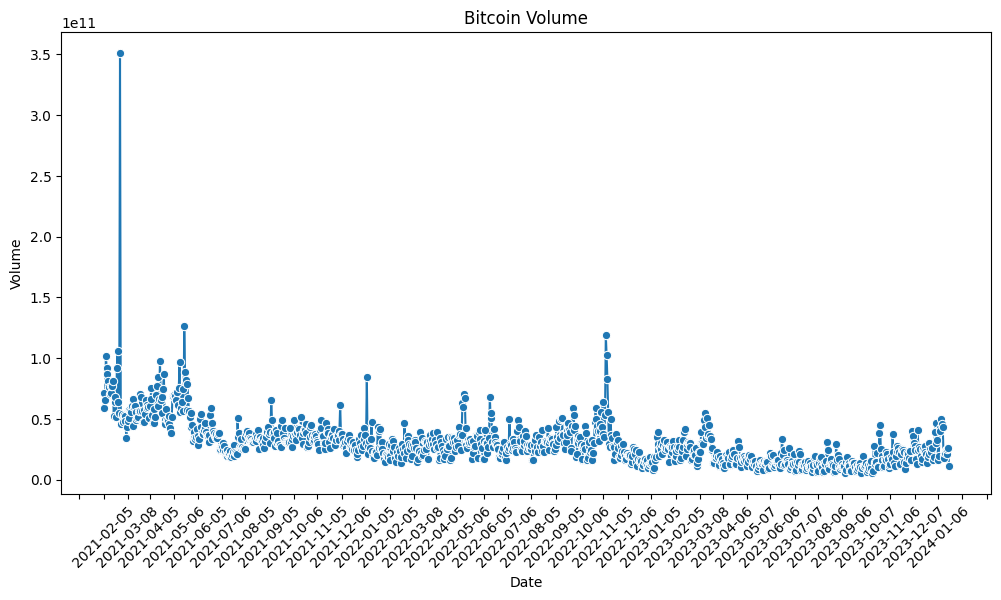

In [40]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Volume', data=btc_price, marker='o')

plt.title('Bitcoin Volume')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


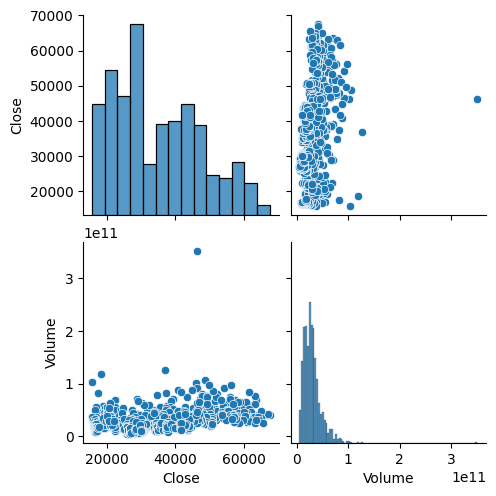

In [41]:
sns.pairplot(btc_price[['Close', 'Volume']])
plt.show()

In [42]:
correlation_matrix = btc_price[['Close', 'Volume']].corr()
print(correlation_matrix)

           Close    Volume
Close   1.000000  0.381198
Volume  0.381198  1.000000


Combine Score and Bitcoin price

In [43]:
#unique_dates = df_small_clean['date'].unique()
#unique_dates = pd.to_datetime(unique_dates)  # Convert to datetime if not already
#unique_dates = sorted(unique_dates.tolist())  # Convert to list, sort, and convert back

#print("Range of Unique Dates:")
#print(unique_dates)

In [44]:
btc_price.rename(columns={'Date': 'date'}, inplace=True)

df_tweets_portion_clean['date_clean'] = pd.to_datetime(df_tweets_portion_clean['date_clean'])
df_tweets_portion_clean['date_clean'] = df_tweets_portion_clean['date_clean'].dt.strftime('%Y-%m-%d')

df_tweets_portion_clean = df_tweets_portion_clean.drop(columns=['date'])
df_tweets_portion_clean.rename(columns={'date_clean': 'date'}, inplace=True)

df_tweets_portion_clean.head()

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,text,...,Vader_Pos,Vader_Neg,Vader_Neu,Vader_Subjectivity,sentiment,Follower_Size,normalized_followers,normalized_user_favorites,Weighted_Compound_Score,Weighted_Subjectivity_Score
2295827,103688,Boosten,Colorado,#Crypto #BTC #Trader Currently managing +$1M ...,2020-12-03 06:37:27,10399,724,226,False,"El Salvador President: ""We've seen benefits fr...",...,0.298,0.0,0.702,0.298,POSITIVE,10000 - 99999 followers,0.000431,0.000144,0.625475,0.298575
2295469,102927,Rainbow Runner,NFA,Founder & Head Dev of Rainbow Trends ...,2019-05-13 02:05:57,5073,1276,19118,False,#Bitcoin - Tight Range https://t.co/ukbDb8mNju,...,0.0,0.0,1.0,0.0,NEUTRAL,1000 - 9999 followers,0.00021,0.012193,0.012404,0.012404
2295455,102901,XForceGlobal (Sun Tzu),Location: Your Heart,• Trusted/Top TradingView Educator • Unbiased ...,2019-06-22 11:06:38,12798,149,12409,False,$BTC Shorter Timeframe Analysis There are ple...,...,0.058,0.0,0.942,0.058,NEUTRAL,10000 - 99999 followers,0.00053,0.007914,0.210745,0.066445
2295456,102904,Milb0t,The Matrix,💰 💰 Automated #trading #bitcoin #eth #shitcoin...,2016-06-01 00:59:47,19,1,11,False,22627.28 #Bitcoin crossing crossing 1st level ...,...,0.0,0.0,1.0,0.0,NEUTRAL,10 - 99 followers,0.000001,0.000007,0.000008,0.000008
2295457,102907,Kesha Glover,United States,"Crypto investor and Market Researcher, sharing...",2009-06-05 15:23:40,1,0,0,False,I'm not bothered where #bitcoin is going at th...,...,0.228,0.103,0.67,0.33,NEUTRAL,Other,0.0,0.0,0.4215,0.33


In [45]:
from scipy.interpolate import UnivariateSpline
from matplotlib.dates import date2num, num2date
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Objective_Users_Weighted_Compound.rename(columns = {'Weighted_Compound_Score':'Objective_Weighted_Compound'}, inplace = True) 
Subjective_Users_Weighted_Compound.rename(columns = {'Weighted_Compound_Score':'Subjective_Weighted_Compound'}, inplace = True) 
Objective_Users_Weighted_Subjectivity.rename(columns = {'Weighted_Subjectivity_Score':'Objective_Weighted_Subjectivity_Score'}, inplace = True) 
Subjective_Users_Weighted_Subjectivity.rename(columns = {'Weighted_Subjectivity_Score':'Subjective_Weighted_Subjectivity_Score'}, inplace = True) 



#merged_df0 = pd.merge(df_tweets_portion_clean, btc_price, on='date', how='inner')
#merged_df0.shape

merged_df = pd.merge(btc_price, weighted_average_compound_score, on='date', how='left')
merged_df.shape

merged_df1 = pd.merge(merged_df, weighted_average_subjectivity_score, on='date', how='left')
merged_df1.shape

merged_df2 = pd.merge(merged_df1, Objective_Users_Weighted_Subjectivity, on='date', how='left')
merged_df2.shape

merged_df3 = pd.merge(merged_df2, Subjective_Users_Weighted_Subjectivity, on='date', how='left')
merged_df3.shape

merged_df4 = pd.merge(merged_df3, Objective_Users_Weighted_Compound, on='date', how='left')
merged_df4.shape

merged_df5 = pd.merge(merged_df4, Subjective_Users_Weighted_Compound, on='date', how='left')


# Sort the DataFrame by 'date'
merged_df5 = merged_df5.sort_values(by='date')

#merged_df['date'] = date2num(merged_df['date'])

#weighted_average_compound_score.head()
merged_df5.head()
merged_df5.shape
duplicates = merged_df5['date'].duplicated()
merged_df5['duplicate'] = duplicates

#btc_price = btc_price[btc_price['Date'] != '2024-01-20']

merged_df5_deduped = merged_df5[merged_df5['duplicate'] == True]

#print(merged_df5_deduped)
merged_df5_deduped.shape




(1080, 4)

(1080, 5)

(1080, 6)

(1080, 7)

(1080, 8)

,date,Close,Volume,Weighted_Average_Compound_Score,Weighted_Average_Subjectivity_Score,Objective_Weighted_Subjectivity_Score,Subjective_Weighted_Subjectivity_Score,Objective_Weighted_Compound,Subjective_Weighted_Compound
0,2021-02-05,38144.308594,5.859807e+10,0.131261,0.121714,0.054832,<NA>,0.077564,<NA>
1,2021-02-06,39266.011719,7.132603e+10,0.124725,0.112577,0.051539,<NA>,0.071142,<NA>
2,2021-02-07,38903.441406,6.550064e+10,0.129793,0.110875,0.054224,<NA>,0.074735,<NA>
3,2021-02-08,46196.464844,1.014672e+11,0.156349,0.130248,0.064291,<NA>,0.089984,<NA>
4,2021-02-09,46481.105469,9.180985e+10,0.137911,0.12664,0.063695,<NA>,0.0759,<NA>


(1080, 9)

(0, 10)

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weighted_Average_Compound_Score')

Text(0, 0.5, 'Close')

Text(0.5, 1.0, 'weighted_average_compound_score vs Price for all Tweets')

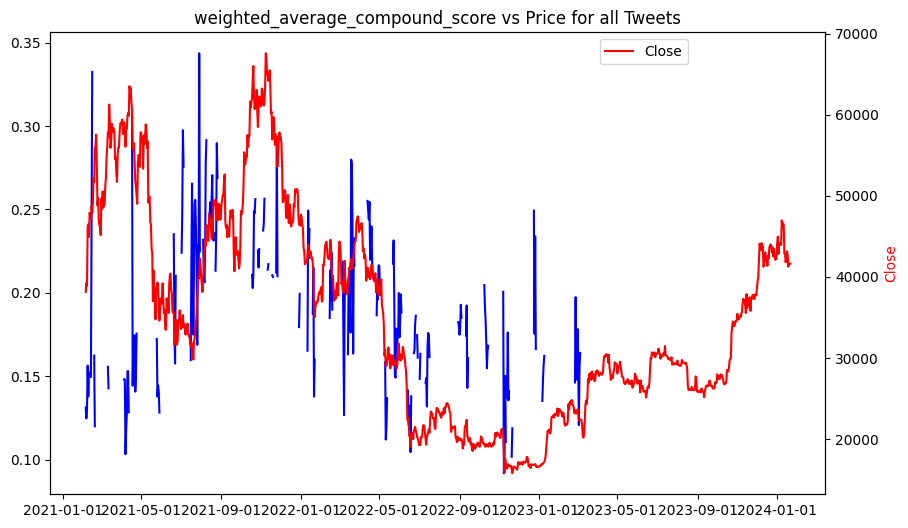

In [46]:
merged_df5['date'] = pd.to_datetime(merged_df5['date'])

# Calculate average scores by date
#average_score_df = merged_df5.groupby('date')['weighted_average_compound_score'].mean().reset_index()

plt.figure(figsize=(10, 6))

plt.plot(merged_df5['date'], merged_df5['Weighted_Average_Compound_Score'], label='Weighted_Average_Compound_Score', color='blue')

plt2 = plt.gca().twinx()
plt2.plot(merged_df5['date'], merged_df5['Close'], label='Close', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date')
plt.ylabel('Weighted_Average_Compound_Score', color='blue')
plt2.set_ylabel('Close', color='red')
plt.title('weighted_average_compound_score vs Price for all Tweets')

plt.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0))

plt.show()

In [47]:
# Sort by 'value' in descending order within each date group
sorted_df = df_tweets_portion_clean.sort_values('Weighted_Compound_Score', ascending=False).reset_index(drop=True)

#sorted_df = df_tweets_portion_clean.sort_values('Weighted_Compound_Score', ascending=False, by='date')

# Select the top 10 rows within each date group
top_10_per_date = sorted_df.groupby('date').head(10)

# Calculate the mean of 'value' grouped by date
top_favorites_df = top_10_per_date.groupby('date')['Weighted_Compound_Score'].mean().reset_index()

top_favorites_df  = top_favorites_df.rename(columns={'Weighted_Compound_Score': 'Avg top 10 score'})

top_favorites_df['date'] = pd.to_datetime(top_favorites_df ['date'])

merged_df5 = pd.merge(merged_df5, top_favorites_df, on='date', how='left')

#top_favorites_df = top_favorites_df
merged_df5.head()
merged_df5.shape

,date,Close,Volume,Weighted_Average_Compound_Score,Weighted_Average_Subjectivity_Score,Objective_Weighted_Subjectivity_Score,Subjective_Weighted_Subjectivity_Score,Objective_Weighted_Compound,Subjective_Weighted_Compound,duplicate,Avg top 10 score
0,2021-02-05,38144.308594,5.859807e+10,0.131261,0.121714,0.054832,<NA>,0.077564,<NA>,False,0.862135
1,2021-02-06,39266.011719,7.132603e+10,0.124725,0.112577,0.051539,<NA>,0.071142,<NA>,False,0.888388
2,2021-02-07,38903.441406,6.550064e+10,0.129793,0.110875,0.054224,<NA>,0.074735,<NA>,False,0.897918
3,2021-02-08,46196.464844,1.014672e+11,0.156349,0.130248,0.064291,<NA>,0.089984,<NA>,False,0.922217
4,2021-02-09,46481.105469,9.180985e+10,0.137911,0.12664,0.063695,<NA>,0.0759,<NA>,False,0.922584


(1080, 11)

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weighted_Average_Compound_Score')

Text(0, 0.5, 'Close')

Text(0.5, 1.0, 'Weighted_Average_Compound_Score and Price for Top-10 Tweets Each Day')

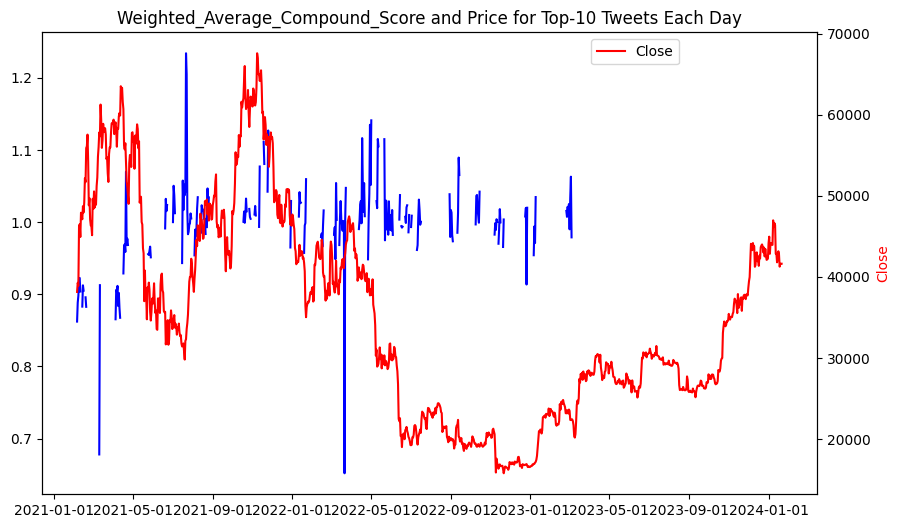

In [48]:
#average_score_df = top_favorites_df.groupby('date')['score'].mean().reset_index()

plt.figure(figsize=(10, 6))

plt.plot(merged_df5 ['date'], merged_df5 ['Avg top 10 score'], label='Avg top 10 score', color='blue')

plt2 = plt.gca().twinx()

plt2.plot(merged_df5 ['date'], merged_df5 ['Close'], label='Close', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date')
plt.ylabel('Weighted_Average_Compound_Score', color='blue')
plt2.set_ylabel('Close', color='red')
plt.title('Weighted_Average_Compound_Score and Price for Top-10 Tweets Each Day')

plt.legend(loc='upper left', bbox_to_anchor=(0.7, 1.0))

plt.show()

In [49]:
merged_df5.head()

,date,Close,Volume,Weighted_Average_Compound_Score,Weighted_Average_Subjectivity_Score,Objective_Weighted_Subjectivity_Score,Subjective_Weighted_Subjectivity_Score,Objective_Weighted_Compound,Subjective_Weighted_Compound,duplicate,Avg top 10 score
0,2021-02-05,38144.308594,5.859807e+10,0.131261,0.121714,0.054832,<NA>,0.077564,<NA>,False,0.862135
1,2021-02-06,39266.011719,7.132603e+10,0.124725,0.112577,0.051539,<NA>,0.071142,<NA>,False,0.888388
2,2021-02-07,38903.441406,6.550064e+10,0.129793,0.110875,0.054224,<NA>,0.074735,<NA>,False,0.897918
3,2021-02-08,46196.464844,1.014672e+11,0.156349,0.130248,0.064291,<NA>,0.089984,<NA>,False,0.922217
4,2021-02-09,46481.105469,9.180985e+10,0.137911,0.12664,0.063695,<NA>,0.0759,<NA>,False,0.922584


Final table

In [50]:





merged_df5 = merged_df5.rename(columns={'date': 'Date', 'Weighted_Compound_Score_top10': 'Avg top 10 score', 'Close': 'Bitcoin price'})
merged_df5 = merged_df5[['Date', 'Bitcoin price', 'Volume', 'Weighted_Average_Compound_Score', 'Weighted_Average_Subjectivity_Score','Avg top 10 score','Objective_Weighted_Compound','Subjective_Weighted_Compound','Objective_Weighted_Subjectivity_Score','Subjective_Weighted_Subjectivity_Score']]
order = ['Date', 'Bitcoin price', 'Volume', 'Weighted_Average_Compound_Score', 'Weighted_Average_Subjectivity_Score','Avg top 10 score','Objective_Weighted_Compound','Subjective_Weighted_Compound','Objective_Weighted_Subjectivity_Score','Subjective_Weighted_Subjectivity_Score']
merged_df5 = merged_df5[order]

merged_df5.head()
merged_df5.shape
merged_df5.describe()
merged_df5.info()
#merged_df5.to_csv('Final_BTC.csv', index=False)

,Date,Bitcoin price,Volume,Weighted_Average_Compound_Score,Weighted_Average_Subjectivity_Score,Avg top 10 score,Objective_Weighted_Compound,Subjective_Weighted_Compound,Objective_Weighted_Subjectivity_Score,Subjective_Weighted_Subjectivity_Score
0,2021-02-05,38144.308594,5.859807e+10,0.131261,0.121714,0.862135,0.077564,<NA>,0.054832,<NA>
1,2021-02-06,39266.011719,7.132603e+10,0.124725,0.112577,0.888388,0.071142,<NA>,0.051539,<NA>
2,2021-02-07,38903.441406,6.550064e+10,0.129793,0.110875,0.897918,0.074735,<NA>,0.054224,<NA>
3,2021-02-08,46196.464844,1.014672e+11,0.156349,0.130248,0.922217,0.089984,<NA>,0.064291,<NA>
4,2021-02-09,46481.105469,9.180985e+10,0.137911,0.12664,0.922584,0.0759,<NA>,0.063695,<NA>


(1080, 10)

,Date,Bitcoin price,Volume,Weighted_Average_Compound_Score,Weighted_Average_Subjectivity_Score,Avg top 10 score,Objective_Weighted_Compound,Subjective_Weighted_Compound,Objective_Weighted_Subjectivity_Score,Subjective_Weighted_Subjectivity_Score
count,1080,1080.000000,1.080000e+03,231.0,231.0,231.0,231.0,175.0,231.0,175.0
mean,2022-07-29 12:01:20,34994.502595,3.056673e+10,0.19012,0.165514,0.998232,0.097868,0.28238,0.062175,0.844146
min,2021-02-05 00:00:00,15787.284180,5.331173e+09,0.091823,0.110875,0.651885,0.044172,-0.989251,0.044866,0.80785
25%,2021-11-01 18:00:00,24418.755859,1.836366e+10,0.155216,0.152597,0.98132,0.080121,0.119582,0.058835,0.833677
50%,2022-07-29 12:00:00,31953.751953,2.721259e+10,0.184875,0.16987,1.003638,0.098514,0.354624,0.062063,0.844075
75%,2023-04-25 06:00:00,43928.862305,3.710426e+10,0.220586,0.17894,1.023496,0.114307,0.516686,0.065463,0.853172
max,2024-01-21 00:00:00,67566.828125,3.509679e+11,0.3436,0.216398,1.233991,0.176046,0.971881,0.090246,0.940649
std,NaN,12692.145887,1.936641e+10,0.046892,0.021993,0.061255,0.0239,0.368767,0.005405,0.019258


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    1080 non-null   datetime64[ns]
 1   Bitcoin price                           1080 non-null   float64       
 2   Volume                                  1080 non-null   float64       
 3   Weighted_Average_Compound_Score         231 non-null    Float64       
 4   Weighted_Average_Subjectivity_Score     231 non-null    Float64       
 5   Avg top 10 score                        231 non-null    Float64       
 6   Objective_Weighted_Compound             231 non-null    Float64       
 7   Subjective_Weighted_Compound            175 non-null    Float64       
 8   Objective_Weighted_Subjectivity_Score   231 non-null    Float64       
 9   Subjective_Weighted_Subjectivity_Score  175 non-null

In [51]:
# Add Vix, S&P 500, Greedy_Fear Index

!pip install yfinance
import yfinance as yf
import datetime



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.1 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-cp310-cp310-linux_x86_64.whl size=317953 sha256=4db2f62311521a40275b24d414e94dee29b5f4fafe9916f0d02aded573cb618a
  Stored in directory: /root/.cache/pip/wheels/fd/fd/5e/90b9ec95da4fd6c96237b580ce74f89d6bdea547ad151ab5f4
Successfully built peewee


In [52]:
# Construct the ticker for the VIX
vix_ticker = yf.Ticker("^VIX")

# Get today's date
today = datetime.date.today().strftime('%Y-%m-%d')

# Use the history method to fetch the data
vix_data = vix_ticker.history(start="2021-02-05", end=today)

# Resetting the index to have Date as a column
vix_data.reset_index(inplace=True)

#
vix_data['Date'] = pd.to_datetime(vix_data['Date'], format = '%Y-%m')
#vix_data['Date'] = pd.to_datetime(vix_data['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Resetting the index to have Date as a column
vix_data.reset_index(inplace=True)

vix_data['Date'] = vix_data['Date'].dt.tz_localize(None)

vix_data['Date'] = vix_data['Date'].astype('datetime64[ns]')

vix_data.head(1)
vix_data.info()

,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0,2021-02-05,21.99,22.16,20.860001,20.870001,0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         1026 non-null   int64         
 1   Date          1026 non-null   datetime64[ns]
 2   Open          1026 non-null   float64       
 3   High          1026 non-null   float64       
 4   Low           1026 non-null   float64       
 5   Close         1026 non-null   float64       
 6   Volume        1026 non-null   int64         
 7   Dividends     1026 non-null   float64       
 8   Stock Splits  1026 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 72.3 KB


In [53]:


# Selecting columns and converting column names to lowercase
vix_data.columns = vix_data.columns.to_series().apply(lambda x: x.strip())
vix_data = vix_data[["Date", "Close"]]
vix_data = vix_data.rename(columns={'Close': 'VIX'})


In [54]:
#Merge Vix the Final_dataset
merged_df5_vix = pd.merge(merged_df5, vix_data, on='Date', how='left')

#vix_data.head()
#vix_data.shape
#vix_data.describe()
#vix_data.info()
#merged_df5.info()




In [55]:
#SP500 

SP_500= yf.Ticker("^GSPC")


# Use the history method to fetch the data
SP_500 = SP_500.history(start="2021-02-05", end=today)


# Resetting the index to have Date as a column
SP_500.reset_index(inplace=True)

# Selecting columns and converting column names to lowercase
SP_500 = SP_500[['Date', 'Close']]
SP_500 = SP_500.rename(columns={'Close': 'SP500'})

SP_500['Date'] = SP_500['Date'].dt.tz_localize(None)
SP_500['Date'] = SP_500['Date'].astype('datetime64[ns]')


#Merge Vix the Final_dataset
merged_df5_vix_SP500 = pd.merge(merged_df5_vix, SP_500, on='Date', how='left')


#merged_df5_vix_SP500.head()
#merged_df5_vix_SP500.shape
#merged_df5_vix_SP500.describe()

merged_df5_vix_SP500.to_csv('Final_BTC_VIX_500.csv', index=False)

